# Odometry Reconstruction Accuracy Results

 * **Warning:** quite a bit of copypasta from the 'DepthAnalysis' notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

%matplotlib inline

from matplotlib import rc
# Enable full LaTeX support in plot text. Requires a full-fledged LaTeX installation
# on your system, accessible via PATH.
rc('text', usetex=True)

plt.rcParams["figure.figsize"] = (16, 6)
matplotlib.rcParams.update({'font.size': 16})

Saved figure to [odo-acc-static-depth-result].    
Saved figure to [odo-completeness-static-depth-result].    
Saved figure to [odo-acc-dynamic-depth-result].    
Saved figure to [odo-completeness-dynamic-depth-result].    


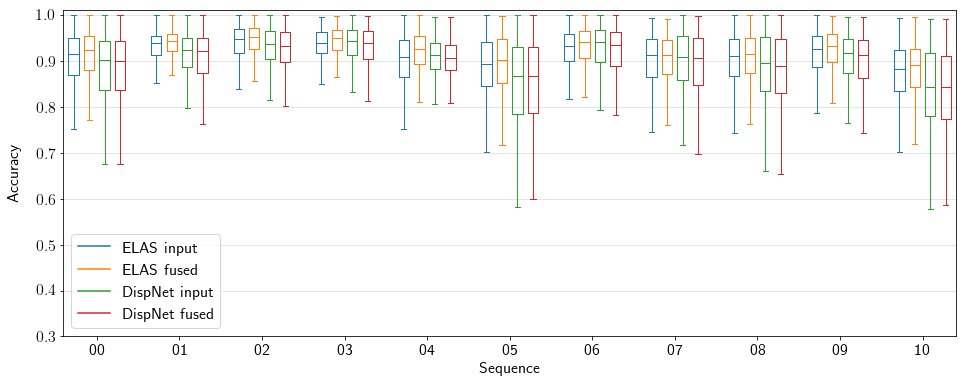

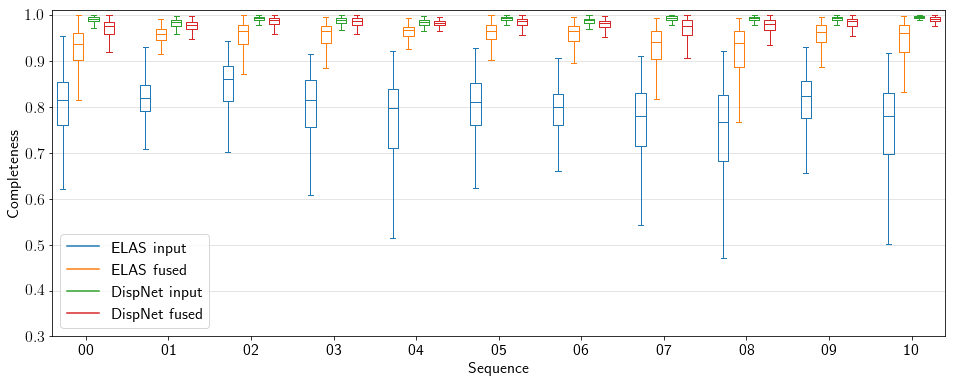

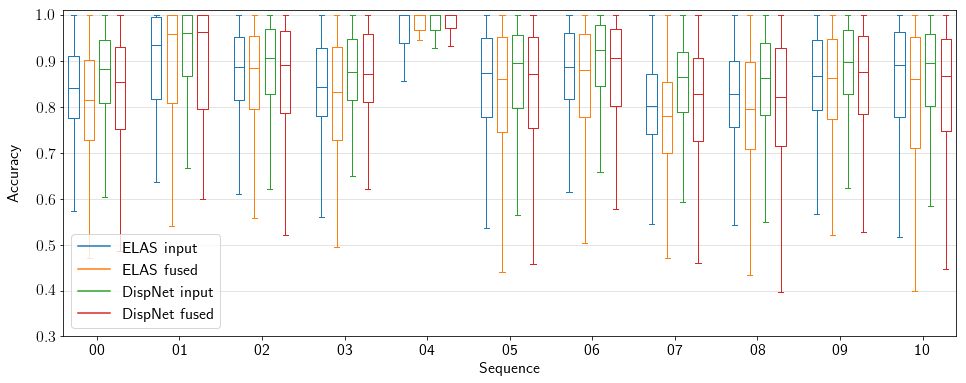

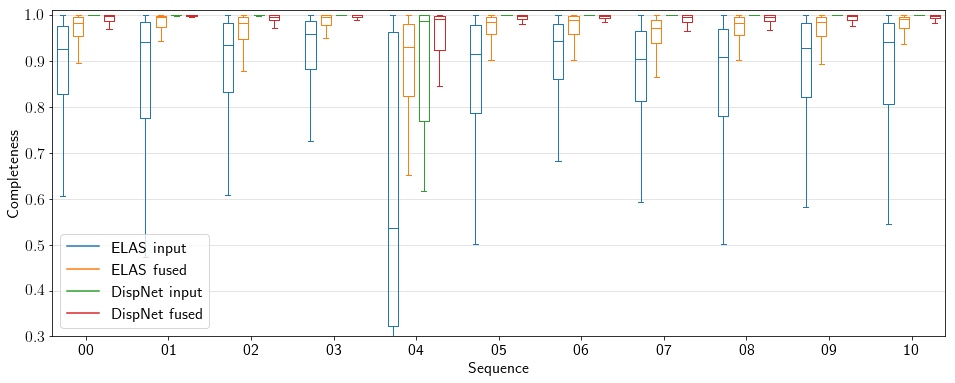

In [55]:
out_dir = '../fig'

def gen_plots(root, part):
    file_pattern = 'k-99999-kitti-odometry-{sequence_id:02d}-offset-0-depth-precomputed-{depth}-' \
                   'voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-' \
                   'with-fusion-weights-{part}.csv'
    base = os.path.join(root, file_pattern)
    res = {}
    res_completeness = {}
    
    sequences = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    metrics = ['input', 'fusion']
    depths = ['elas', 'dispnet']
    
    # Load the data and prepare some positioning and color info
    # (Since we're doing a nontrivial plot, which means we need to do a lot of
    #  stuff manually.)
    box_positions = []
    box_colors = []
    columns = []
    box_offset = 0.0
    INNER_GAP = 0.75
    SEQUENCE_GAP = 1.0
    GROUP_SIZE = len(depths) * len(metrics)
    
    colors = {
        'elas': {
            'input': 'C0',
            'fusion': 'C1',
        },
        'dispnet': {
            'input': 'C2',
            'fusion': 'C3'
        }
    }
    
    def setup_xaxis_legend(ax, **kw):
        bp_np = np.array(box_positions)
        alt_ticks = bp_np[np.arange(len(bp_np)) % GROUP_SIZE == 0] + (INNER_GAP*(GROUP_SIZE-1.0)/2.0)
        ax.set_xticks(alt_ticks)
        ax.set_xticklabels("{:02d}".format(sid) for sid in sequences)
        ax.set_xlabel("Sequence")

        ax.set_ylim([0.0, 1.0])

        for patch, color in zip(boxplot['medians'], box_colors):
            patch.set_color(color)    

        for patch, color in zip(boxplot['boxes'], box_colors):
            patch.set_color(color)

        # Ugly, but required since every box has two whiskers and two caps...
        for idx, (whisker, cap) in enumerate(zip(boxplot['whiskers'], boxplot['caps'])):
            cap.set_color(box_colors[idx%(2*GROUP_SIZE) // 2])
            whisker.set_color(box_colors[idx%(2*GROUP_SIZE) // 2])   

        # Dummies for showing the appropriate legend
        ax.plot([0.0], [-1000], label="ELAS input", color=colors['elas']['input'])
        ax.plot([0.0], [-1000], label="ELAS fused", color=colors['elas']['fusion'])
        ax.plot([0.0], [-1000], label="DispNet input", color=colors['dispnet']['input'])
        ax.plot([0.0], [-1000], label="DispNet fused", color=colors['dispnet']['fusion'])
        ax.legend(loc=kw.get('legendloc', 'lower left'))

        ax.grid('off')
        ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.75)
        
    def save_fig(f, fname):
        print("Saving figure to [{}]... ".format(fname), end='')
        f.savefig(os.path.join(out_dir, fname + '.png'), bbox_inches='tight')
        f.savefig(os.path.join(out_dir, fname + '.eps'), bbox_inches='tight')
        print("\rSaved figure to [{}].    ".format(fname))
        
    
    for sequence_id in sequences:
        for depth in depths:
            # Part dictates what we are evaluating: dynamic or static parts
            fname = base.format(sequence_id=sequence_id, depth=depth, part=part)
            df = pd.read_csv(fname)
            
            for metric in metrics:
                key = "{}-{}-{:02d}".format(metric, depth, sequence_id)
                
                # Do not count frames with no pixels in them. This would distort the 
                # dynamic reconstruction metrics due to frames containing no objects.
                ok = (df['{}-total-3.00-kitti'.format(metric)] != 0)

                err = df['{}-error-3.00-kitti'.format(metric)][ok]
                tot = df['{}-total-3.00-kitti'.format(metric)][ok]
                mis = df['{}-missing-3.00-kitti'.format(metric)][ok]
                cor = df['{}-correct-3.00-kitti'.format(metric)][ok]
                mis_sep = df['{}-missing-separate-3.00-kitti'.format(metric)][ok]

                acc_perc = cor / (tot - mis)
                res[key] = acc_perc
                
                completeness = 1.0 - (mis_sep / tot)
                res_completeness[key] = completeness
                
                box_colors.append(colors[depth][metric])
                
                columns.append(key)
                box_positions.append(box_offset)
                box_offset += INNER_GAP
            
        box_offset += SEQUENCE_GAP
    

    ################################################################################
    # Accuracy plots
    ################################################################################
    res_df = pd.DataFrame(res)    
    FIG_SIZE = (16, 6)
    fig = plt.figure(figsize=FIG_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    (ax, boxplot) = res_df.boxplot(columns, showfliers=False, 
                                   return_type='both',
                                   widths=0.50, 
                                   ax=ax, 
#                                    patch_artist=True,  # Enable fill
                                   positions=box_positions)
    setup_xaxis_legend(ax)
    ax.set_ylabel("Accuracy", labelpad=15)
    ax.set_ylim([0.3, 1.01])
    save_fig(fig, 'odo-acc-{}'.format(part))
    
    ################################################################################
    # Completeness plots
    ################################################################################
    res_completeness_df = pd.DataFrame(res_completeness)
    fig = plt.figure(figsize=FIG_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    
    (ax, boxplot) = res_completeness_df.boxplot(columns, showfliers=False, 
                                               return_type='both',
                                               widths=0.50, 
                                               ax=ax, 
            #                                    patch_artist=True,  # Enable fill
                                               positions=box_positions)
    
    setup_xaxis_legend(ax)
    ax.set_ylim([0.3, 1.01])
    ax.set_ylabel("Completeness")
    
    save_fig(fig, 'odo-completeness-{}'.format(part))
                
        
gen_plots('../csv/odo-res', 'static-depth-result')
gen_plots('../csv/odo-res', 'dynamic-depth-result')